## Statistical Inference

> Inferr parameters from data with **theoretical guarantees**.

In [169]:
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats

%config InlineBackend.figure_format = 'retina'
sns.set()
rand = np.random.RandomState(95)

In [170]:
n = 20
p = 20000

μ = 0
σ = 4

# k=2
# θ=3

Let's say we want to know the mean of some measurement. We know that this data is normally distributed.

In [171]:
u = rand.normal(μ, σ, size=n)
print(f'Mean: {np.mean(u):.4f}')

alt.Chart(pd.DataFrame(u)).mark_circle().encode(
    alt.X('0:Q', title='')
)

Mean: 0.5654


alt.Chart(...)

But how confident are we in this mean? Are we willing to bet someone's lives on this?

### Let's find out.

In [172]:
x = rand.normal(μ, σ, size=(n, p))
# x = rand.gamma(k, θ, size=(n, p))

Here, we create $p$ samples of $n$ measurements from a Gaussian population with mean $\mu$ and standard deviation $\sigma$.

Or in random variable terms for each sample,
$$
X_{1} \dots, X_{n} \overset{\text{i.i.d.}}{\sim} \mathrm{Normal}(\mu, \sigma^2).
$$

In [173]:
df = pd.DataFrame(x)
kwargs_melt = dict(var_name='sample', value_name='measurement')

sam = 20
base = alt.Chart(df.sample(sam, axis=1).melt(**kwargs_melt))

# ruler = base.mark_rule(color='gray', strokeOpacity=0.9, size=2).encode(
#     x='mu:Q'
# ).transform_calculate(mu=str(μ))

ticks = base.mark_circle(opacity=0.8, size=14).encode(
    x=alt.X('measurement:Q', title=''),
    y=alt.Y('sample:N'),
    color=alt.Color('sample:N')
)

error = base.mark_errorbar(opacity=0.2).encode(
    x='measurement:Q',
    y=alt.Y('sample:N')
)

# sample mean
circle = base.mark_tick(opacity=1., size=15, color='black').encode(
    x='mean(measurement):Q',
    y=alt.Y('sample:N')
)

sm = alt.Chart(df.melt(**kwargs_melt).groupby('sample').mean().sample(3000))
kde = sm.mark_area(opacity=0.5).encode(
    x=alt.X('x̄:Q'),
    y=alt.Y('density:Q')
).transform_density(density='measurement', as_=['x̄', 'density']).properties(height=100)

((ticks + error + circle).interactive() & kde).resolve_scale(x='shared')

alt.VConcatChart(...)

What does the distribution of $\bar{x}$ look like?

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Mean of x̄:   0.0043
StDev of x̄:  0.8946


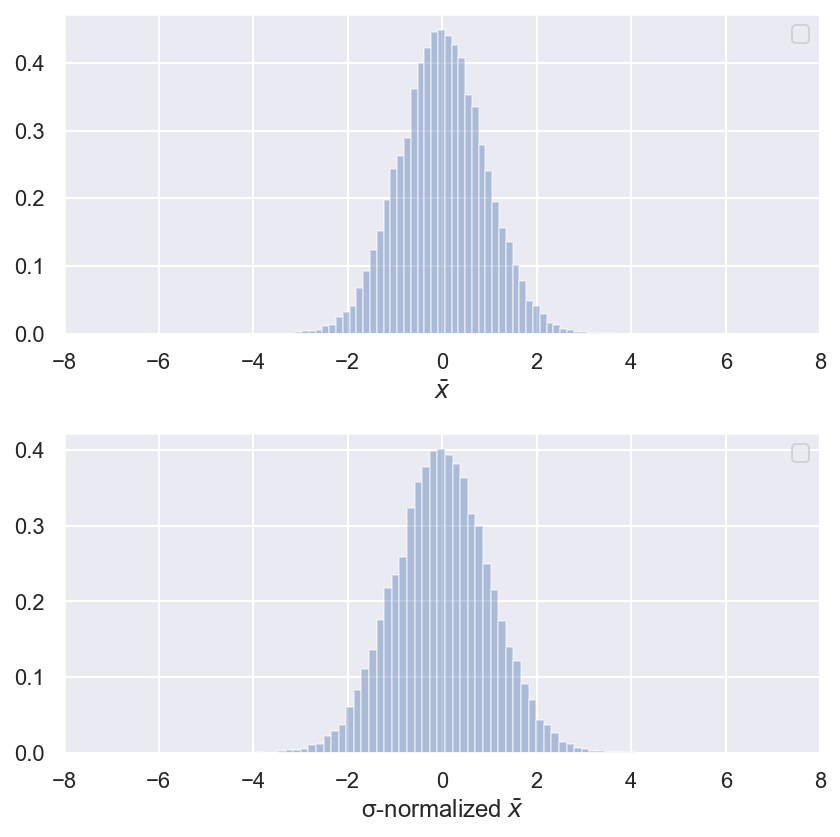

In [174]:
x̄ = np.mean(x, axis=0)
s = np.std(x, axis=0, ddof=1)

print(f'Mean of x̄:  {x̄.mean(): 0.4f}')
print(f'StDev of x̄: {x̄.std(): 0.4f}')

# μ=k*θ
# σ=np.sqrt(k*θ**2)

lim = (μ - 2*σ, μ + 2*σ)

def plot_dist(ax, name, normalize, r, std=σ, fit=False, **kwargs):
    lim = np.linspace(*r, 1000)
    
    if normalize:
        to_plot = x̄ / (std / np.sqrt(n))
        scale = 1
    else:
        to_plot = x̄
        scale = σ / np.sqrt(n)
        
    sns.distplot(np.clip(to_plot, *r), kde=False, norm_hist=True, ax=ax, **kwargs)
    if fit:
        ax.plot(lim, stats.norm.pdf(lim, loc=μ, scale=scale), label=f'Normal({μ}, {scale:.3f})')
    ax.set_xlabel(name)
    ax.set_xlim(r)
    ax.legend()
    return ax

fig, axs = plt.subplots(figsize=(6, 6), nrows=2)
plot_dist(axs[0], '$\\bar{x}$', False, lim)
plot_dist(axs[1], 'σ-normalized $\\bar{x}$', True, lim)
plt.tight_layout()

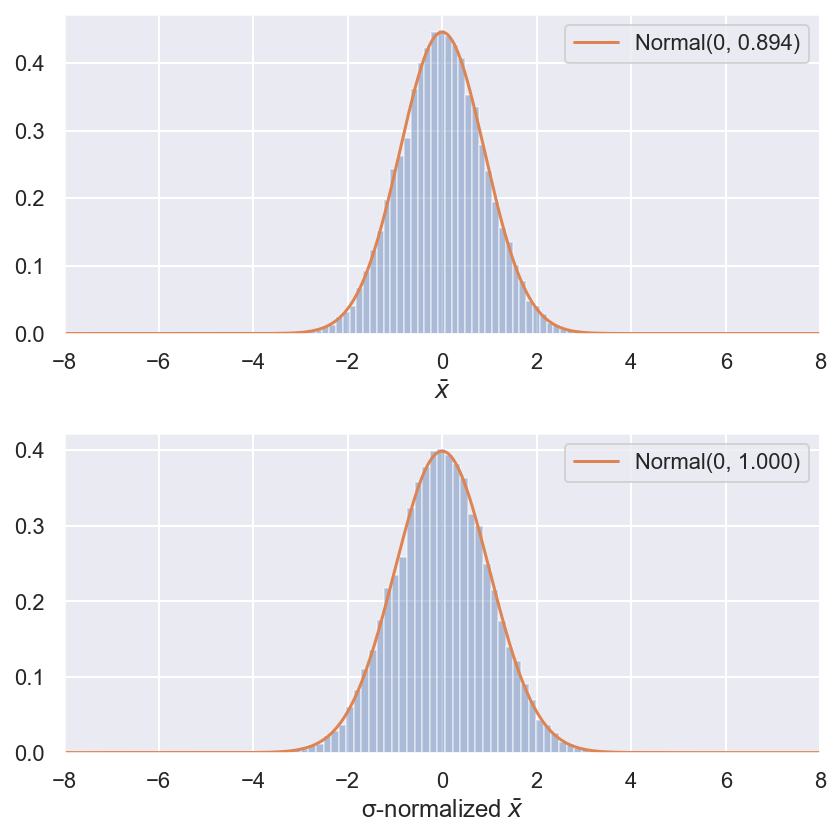

In [175]:
fig, axs = plt.subplots(figsize=(6, 6), nrows=2)
plot_dist(axs[0], '$\\bar{x}$', False, lim, fit=True)
plot_dist(axs[1], 'σ-normalized $\\bar{x}$', True, lim, fit=True)
plt.tight_layout()

In [176]:
1-stats.norm.cdf(0)

0.5

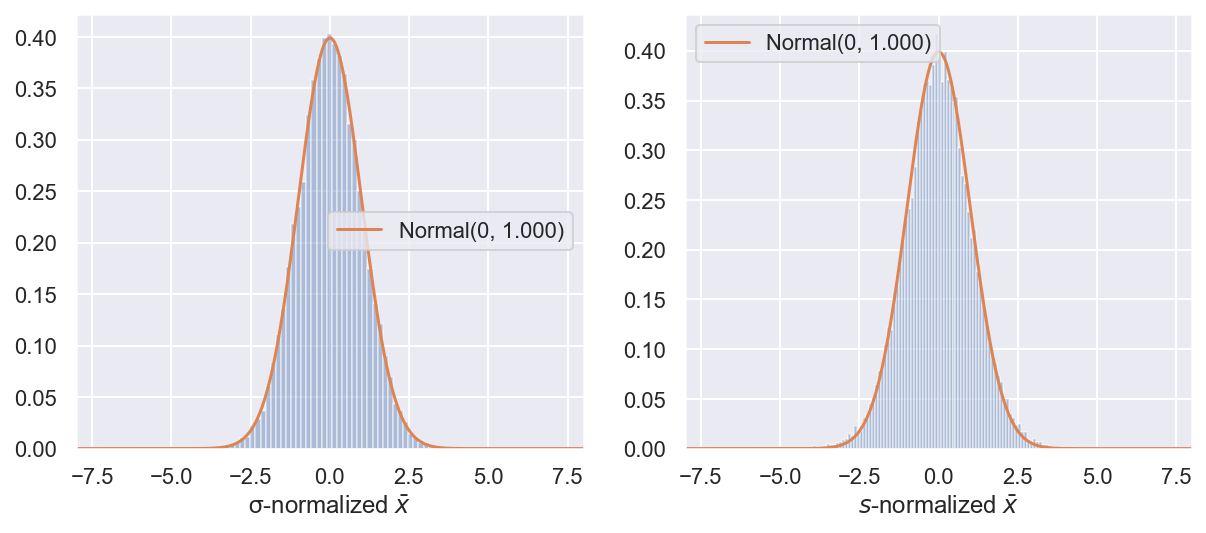

In [177]:
fig, axs = plt.subplots(figsize=(10, 4), ncols=2)
plot_dist(axs[0], 'σ-normalized $\\bar{x}$', True, lim, fit=True)
plot_dist(axs[1], '$s$-normalized $\\bar{x}$', True, lim, std=s, bins=100, fit=True)

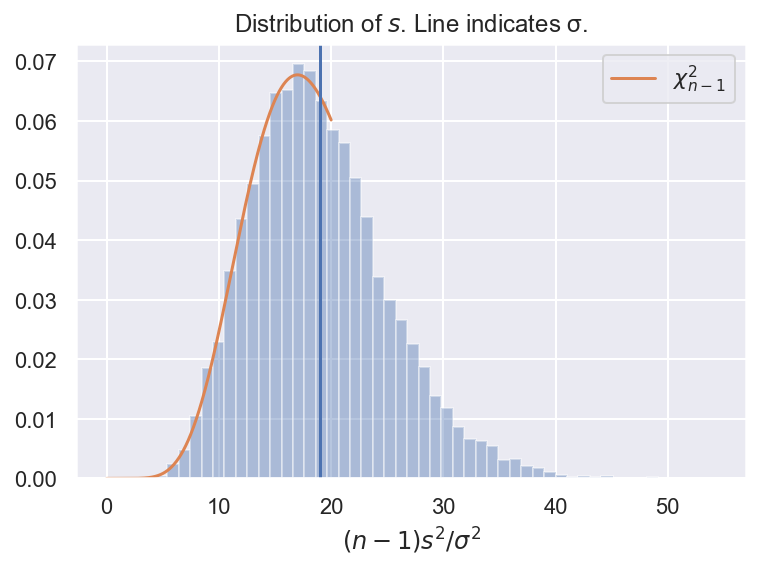

In [178]:
s2 = s**2
ax = sns.distplot((n-1)*s2/σ**2, kde=False, norm_hist=True)

b = np.linspace(0, 20, 1000)
ax.plot(b, stats.chi2(df=n-1).pdf(b), label='$\chi^2_{n-1}$')
ax.axvline(n-1)
ax.set_xlabel('$(n-1)s^2 / \\sigma^2$')
ax.set_title('Distribution of $s$. Line indicates σ.')
ax.legend()

$$
\frac{\bar{x} - \mu}{s/\sqrt{n}} = \frac{\bar{x}-\mu}{\sigma/\sqrt{n}} \frac{1}{s/\sigma} \\
t_{n-1}(0, \sigma^2) \sim \mathrm{Normal}(0, \sigma^2/n) \times \left(\frac{\chi^2(n-1)}{n-1}\right)^{-1/2}
$$

(-6.0, 6.0)

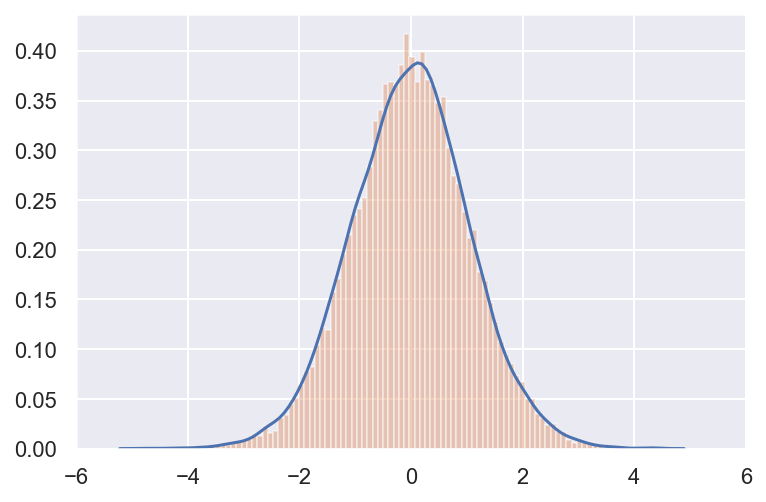

In [179]:
Z = rand.normal(0, 1, size=20000) / np.sqrt(rand.chisquare(n-1, size=20000)/(n-1))
ax = sns.distplot(np.clip(Z, -10, 10), hist=False)
sns.distplot(np.clip(x̄ / (s/np.sqrt(n)), -10, 10), kde=False, norm_hist=True, ax=ax, bins=100)
ax.set_xlim(-6, 6)

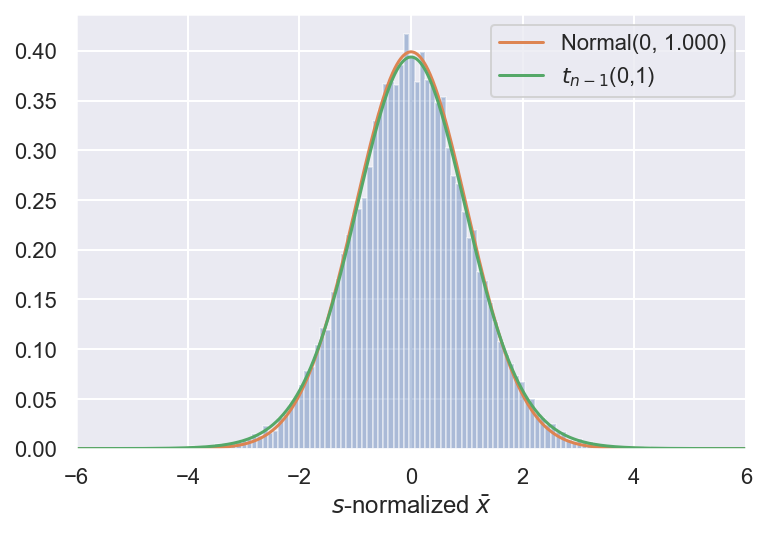

In [180]:
fig, ax = plt.subplots(figsize=(6, 4))
lim = np.linspace(-6, 6, 1000)
plot_dist(ax, '$s$-normalized $\\bar{x}$', True, (-6, 6), std=s, bins=100, fit=True)
ax.plot(lim, stats.t.pdf(lim, df=n-1, loc=μ, scale=1), label='$t_{n-1}$(0,1)')
plt.legend()

Statistical inference is the generalization of _finite_ samples into _infinite_ samples.

$$
\bar{X}_n = \frac{1}{n} \sum_{i=1}^n X_{i} \\
\operatorname{Var}[\bar{X}_n] = \operatorname{Var}\left[ \frac{1}{n} \sum_{i=1}^n X_{i} \right] = \frac{\operatorname{Var}[X]}{n} \\
~\\
\bar{X}_n \overset{d}{\rightarrow} \mathrm{Normal}\left(\mu, \frac{\sigma^2}{n} \right) \\
$$

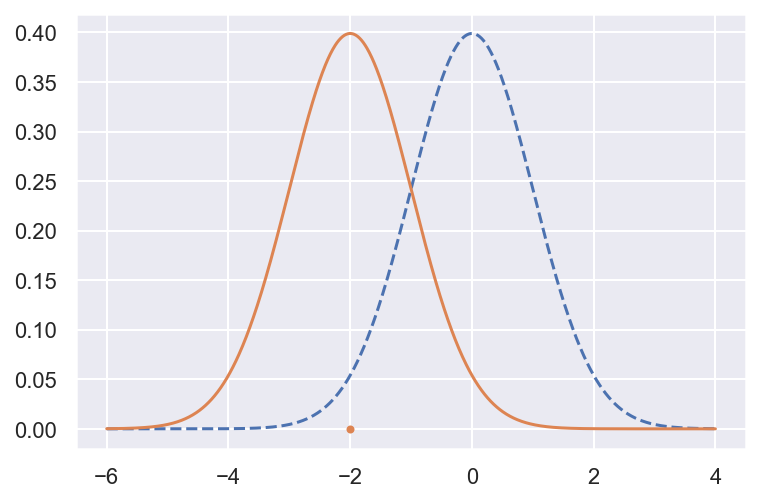

In [181]:
lim = np.linspace(-6, 4, 1000)
scale=1
plt.plot(lim, stats.norm.pdf(lim, loc=μ, scale=1),'--', label=f'Normal({μ}, {scale:.3f})')
plt.plot(lim, stats.norm.pdf(lim, loc=μ-2, scale=1), label=f'Normal({μ}, {scale:.3f})')
plt.plot(-2, 0, '.C1', linewidth=5)


In [182]:
α = 0.95

threshold = stats.norm.interval(α, n-1)[1]

In [183]:
df = pd.DataFrame(x).melt(var_name='sample')
#forbox = pd.DataFrame({'mean': df.groupby('sample').mean(), 'sd': df.groupby('sample').std()})

summary = df.groupby('sample').agg({'value': ['mean', 'std']})['value'].reset_index()
summary['sem'] = sem = summary['std'] / np.sqrt(n)

# sem = df.groupby('sample').std()['value'] / np.sqrt(n)

# forbox['low'] = forbox['value'] - threshold * sem
# forbox['high'] = forbox['value'] + threshold * sem
# forbox['sig'] = (forbox['high'] < μ) | (forbox['low'] > μ)

In [188]:
from altair import datum

base = alt.Chart().transform_calculate(
    low=datum.mean - threshold * datum.sem,
    high=datum.mean + threshold * datum.sem,
    sig=alt.expr.if_((alt.datum.high < μ) | (alt.datum.low > μ), True, False)
)

# slider = alt.binding_range(min=0, max=1, step=10)
# select_year = alt.selection_single(name="year", fields=['year'],
#                                    bind=slider, init={'year': 2000})

points = base.mark_point(
    filled=True,
    color='sig:N'
).encode(
    x='sample:O',
    y='mean:Q',
)

errorbars = base.mark_errorbar().encode(
    x='sample:O',
    y='low:Q',
    y2='high:Q',
    color='sig:N',
    size='sig:N'
)

line = base.mark_rule(color='red').encode(
    y='line:Q'
).transform_calculate(line=str(μ))

text = base.mark_text(align='left', dx=5, dy=-100).encode(
        text=alt.Text('fuck2:N')
).transform_aggregate(fuck=f'mean(low)').transform_calculate(fuck2='datum.fuck + " units"')


alt.layer(errorbars, line, text, points, data=summary.sample(100)
         ).properties(width=800)

alt.LayerChart(...)

In [185]:
summary['low'] = summary['mean'] - threshold * sem
summary['high'] = summary['mean'] + threshold * sem
summary['sig'] = (summary['high'] < μ) | (summary['low'] > μ)
np.mean(summary['sig'])

0.0

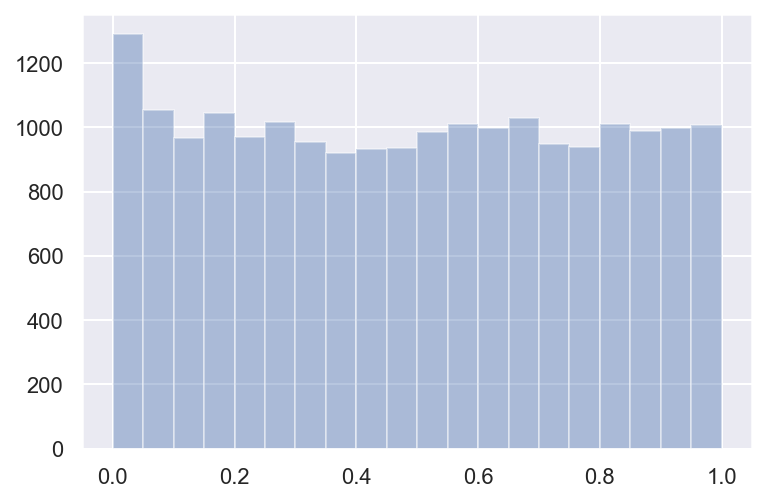

In [186]:
t = (summary['mean'] - μ) / sem
sns.distplot(2 * (1 - stats.norm.cdf(np.abs(t))), kde=False, bins=20)

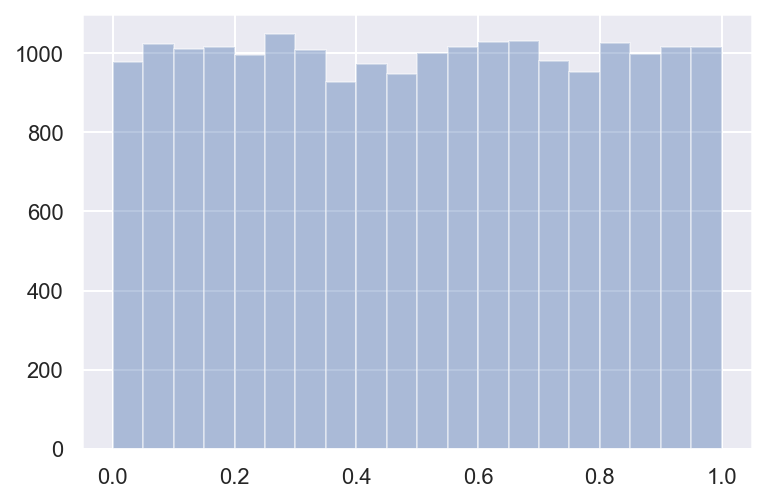

In [187]:
sns.distplot(2 * (1 - stats.t.cdf(np.abs(t), df=n-1)), kde=False, bins=20)

In [83]:
sns.jointplot(2 * (1 - stats.norm.cdf(np.abs(z))), 2 * (1 - stats.t.cdf(np.abs(z), df=n-1)), s=1, alpha=0.5)

NameError: name 'z' is not defined